<a href="https://colab.research.google.com/github/JanTJung/nlp_projects/blob/main/Open_domain_Q_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Open Domain Q.A. system for Covid19

In this assignment you will build an application that performs __information retrieval__ and __question answering__, which are the core tasks that take care the **Open Domain Q.A.** task. 

*   __Information Retrieval__ Retrieve documents with information that is relevant to the user’s information need and helps the user complete a task.

* __Question Answering__ Systems that automatically answer questions posed by humans in a natural language.

The steps are the following:
- Preprocess the data and init models for I.R.
- Preprocess the data and init models for Q.A.
- Implement the functions: retrieve_documents & answer question given a query.
- Run some analysis of the model output.

Note you are not requiered to strictly follow the steps suggested in the notebook as long as you build a model and provide some analysis.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Whoosh
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 468 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 52.5 MB/s 
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 42.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import codecs # base classes for standard Python codecs, like text encodings (UTF-8,...)
from IPython.core.display import display, HTML # object displaying in different formats
from whoosh.index import * # whoosh: full-text indexing and searching
from whoosh.fields import *
from whoosh import qparser
import glob
import seaborn as sns
import random
import matplotlib.pyplot as plt
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import numpy as np


In [ ]:
path="drive/My Drive/Colab Notebooks/nlp-app-II/data/"
count=0
passages=[]
with open(path+'passages') as f:
    for line in f:
      count+=1
      passages.append(line)
      if count == 5000:
          break

print("Number of passages related to 'COVID-19':", count)

Number of passages related to 'COVID-19': 5000


Functions for retrieving the documents and extracting an answer out of the best paper are defined.

In [ ]:

def retrieve_documents(qstring,n_docs):

  scores=[]
  text=[]

  # Open the searcher for reading the index. The default BM25 algorithm will be used for scoring
  with ix.searcher() as searcher:
      searcher = ix.searcher()
      
      # Define the query parser ('text' will be the default field to search), and set the input query
      q = qparser.QueryParser("text", ix.schema, group=qparser.OrGroup).parse(qstring)
  
      # Search using the query q, and get the n_docs documents, sorted with the highest-scoring documents first
      results = searcher.search(q, limit=n_docs)
      # results is a list of dictionaries where each dictionary is the stored fields of the document

  # Iterate over the retrieved documents
  for hit in results:
      scores.append(hit.score)
      text.append(passages[int(hit['id'])])
  return text,scores




def answer_question(question,answer_text):

    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    print('The input has a total of {:} tokens.'.format(len(input_ids)))
    # BERT only needs the token IDs, but for the purpose of inspecting the 
    # tokenizer's behavior, let's also get the token strings and display them.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    #assert len(segment_ids) == len(input_ids)
        
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                                return_dict=True) 


    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Combine the tokens in the answer and print it out.
    answer = ' '.join(tokens[answer_start:answer_end+1])

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
    
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))


    s_score = np.amax(start_scores.detach().numpy().flatten())
    e_score = np.amax(end_scores.detach().numpy().flatten())

    start_scores = start_scores.detach().numpy().flatten()
    end_scores = end_scores.detach().numpy().flatten()

    # Output of answer including scores for start and end are provided
    print('Final answer: "' + answer + '"') 
    print("Score for start of answer: " + str(s_score))
    print("Score for end of answer: " + str(e_score))

    return start_scores, end_scores, token_labels




In [ ]:
# Schema definition:

schema = Schema(id = ID(stored=True,unique=True),
                text = TEXT(analyzer=analysis.StemmingAnalyzer())
              )

# Create an index
if not os.path.exists("index"):
  os.mkdir("index")
ix = create_in("index", schema)
writer = ix.writer() 

for ind,passage_text in enumerate(passages): 
    writer.add_document(id=str(ind),text=passage_text)

# Save the added documents
writer.commit()
print("Index successfully created")
# Sanity check
print("Number of documents (abstracts and paragraphs of papers) in the index: ", ix.doc_count())


model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


Index successfully created
Number of documents (abstracts and paragraphs of papers) in the index:  5000


## Analysis of the output
Analysis is provided for four example sentences. Each of the results are analysed, on two of them is additionally a bar plot analysis apllied about the start and end scores of the answers. (Not all of them as otherwise the notebook would look messy). The two bar plots show one good answer (first one) and a bad one (second one), where the model is insecure about the start and end.

For each answer the scores for finding the correct paper and the start and end scores are provided.


Example 1: Question about the incubation time. 

Answer is very precise and also the paper is returned with a high score.
Furthermore, start and end scores of the answer are visualized.

In [ ]:
query='What is the range of incubation periods for Covid in humans?'
topk_docs, scores=retrieve_documents(query, 5)
print("Best paper found:")
print(topk_docs[0])
print("Score for paper: " +str(scores[0]))
print("\n")
start_scores, end_scores, token_labels = answer_question(query,topk_docs[0])


Best paper found:
There exists an incubation period t c for the development of SARS-CoV-2-related symptoms, which average has been reported to range between 5.2 days [41, 42] and 6.4 days [43] . We can assume the incubation period Statistically-based methodology for revealing real contagion trends and correcting delay-induced errors in the assessment of COVID-19 pandemic follows an exponential distribution with λ = 1 tc :

Score for paper: 22.004387505948458


The input has a total of 116 tokens.
Final answer: "between 5 . 2 days [ 41 , 42 ] and 6 . 4 days [ 43 ]"
Score for start of answer: 5.118279
Score for end of answer: 5.896508


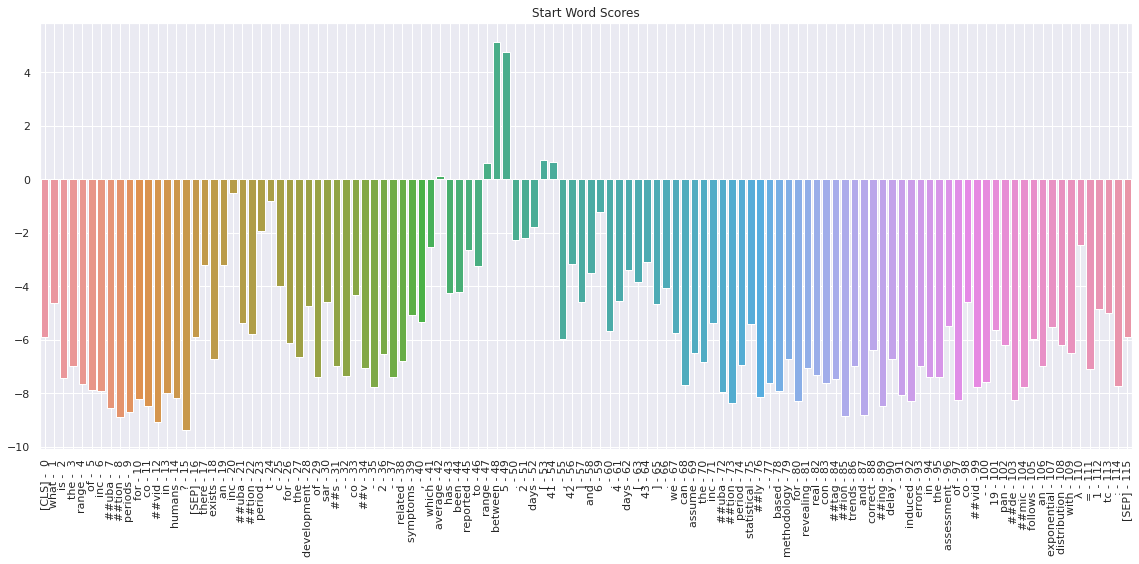

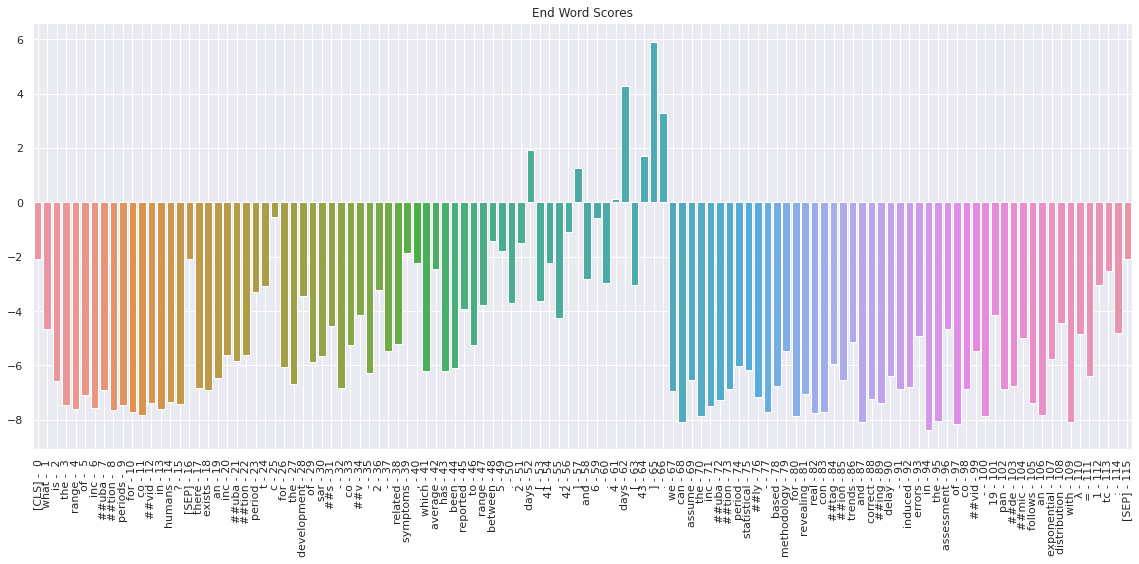

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)
ax = sns.barplot(x=token_labels, y=start_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')
plt.tight_layout()
plt.show()
# Create a barplot showing the start word score for all of the tokens.

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)
ax = sns.barplot(x=token_labels, y=end_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')
plt.tight_layout()
plt.show()

Example 2: Does smoking increase the risk? 

Returned answer gives precise information about which risk is increased. Interesting is that the score for the paper is not too high, even though the answer is perfectly inside.

In [ ]:
query='Does smoking increase the risk of an infection?'
topk_docs, scores = retrieve_documents(query, 5)
print("Best paper found:")
print(topk_docs[0])
print("Score for paper: " +str(scores[0]))
start_scores, end_scores, token_labels = answer_question(query,topk_docs[0])

Best paper found:
Among patients with COVID-19, new-onset CVD increases in individuals who have risk factors, including smoking and diabetes. The Chinese Center for Disease Control and Prevention reported that COVID-19 patients with diabetes had higher mortality [11] . In South Korea, the KCDC reported that as of April 30, 247 deaths occurred, of which 244 are deaths with underlying disease. Among them, the mortality rate of COVID-19 patients with the underlying disease with a metabolic disease or cardiovascular diseases, such as diabetes, stroke, and hypertension [12] . Clinical data characterizing patients with COVID-19 give evidence that CVD risk factors, including smoking and diabetes, are likely associated with negative progression and adverse outcomes of COVID-19 [13] . Recently, a high level of ACE2 has been observed in the brains of smokers [14] . Hence, we consider that smoking and diabetes might increase the ability of SARS-CoV-2 to enter and infect the brain based on the hig

Example 3: Question about the infection period. 

Returns an answer about the antibodies and therefore about the immunity, not the infection itself. Inprecise answer is also shown in very low (negative) scores for possible start and end words. Also the paper score is not too high.

As in the bar plot shown, no correct answer can be extracted from the paper, overall low start and end scores.

In [ ]:
query='How long does a corona virus infection last?'
topk_docs, scores = retrieve_documents(query, 5)
print("Best paper found:")
print(topk_docs[0])
print("Score for paper: " +str(scores[0]))
start_scores, end_scores, token_labels = answer_question(query,topk_docs[0])

Best paper found:
As it is currently unknown how long antibodies against COVID-19 last after primary infection, repetitive antibody testing will be crucial to assess long term immunity in order to develop future vaccines. In addition, several COVID-19 strains with different virulence have been reported [70, 71] . It is not yet known how fast the virus mutates, creating strains for which previously infected (or vaccinated) individuals would no longer be immune to. It will be important to include pregnant woman in vaccination trials, since they are considered a high-risk population [50] .

Score for paper: 18.826235554001336
The input has a total of 131 tokens.
Final answer: "unknown how long antibodies against covid - 19 last after primary infection"
Score for start of answer: -2.3191938
Score for end of answer: -0.89635247


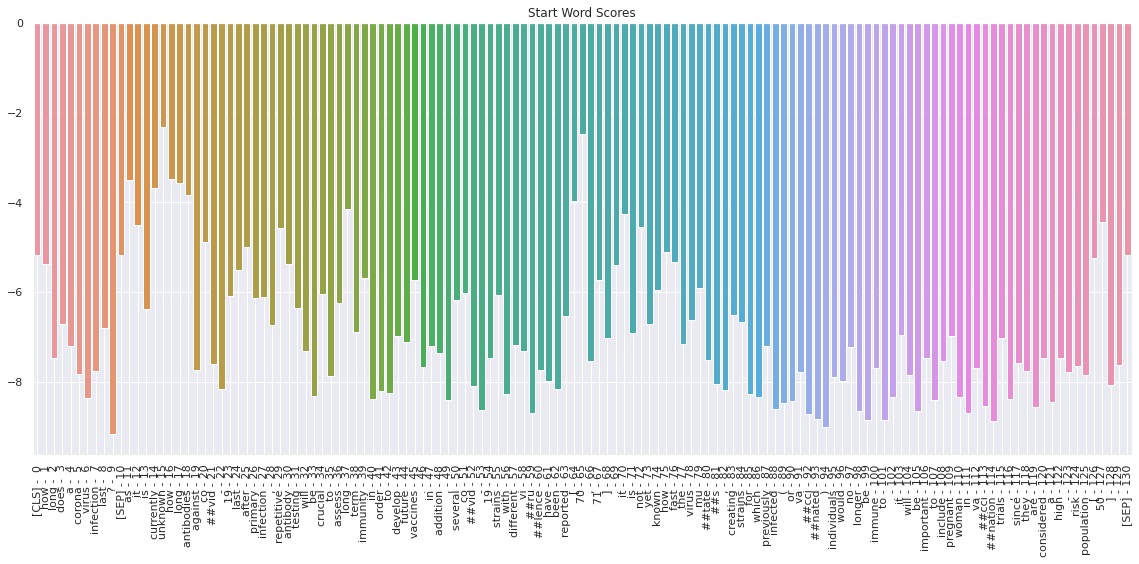

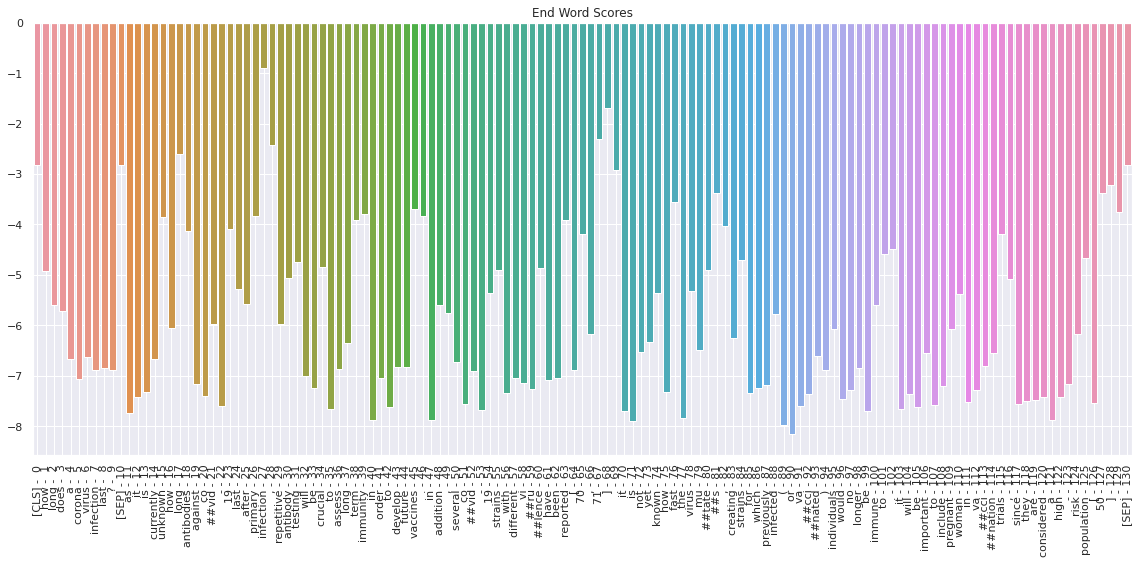

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)
ax = sns.barplot(x=token_labels, y=start_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')
plt.tight_layout()
plt.show()
# Create a barplot showing the start word score for all of the tokens.

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)
ax = sns.barplot(x=token_labels, y=end_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')
plt.tight_layout()
plt.show()

Example 4: Now asking about the immunity (which was unintentionally answered in the question before). Reutrn a very unprecise answer, even though the score for the paper is very high, no good answer could be extracted.

But to be fair, with the current knowledge about Corona this question still cannot be answered, so we can't expect the model to give one.

In [ ]:
query='How long does a immunity against the corona virus last?'
topk_docs, scores = retrieve_documents(query, 5)
print("Best paper found:")
print(topk_docs[0])
print("Score for paper: " +str(scores[0]))
start_scores, end_scores, token_labels = answer_question(query,topk_docs[0])

Best paper found:
As it is currently unknown how long antibodies against COVID-19 last after primary infection, repetitive antibody testing will be crucial to assess long term immunity in order to develop future vaccines. In addition, several COVID-19 strains with different virulence have been reported [70, 71] . It is not yet known how fast the virus mutates, creating strains for which previously infected (or vaccinated) individuals would no longer be immune to. It will be important to include pregnant woman in vaccination trials, since they are considered a high-risk population [50] .

Score for paper: 25.45229041579086
The input has a total of 133 tokens.
Final answer: "long"
Score for start of answer: -0.31911483
Score for end of answer: 0.3276443


#Conclusion

The quality of the results given by the QA modules is mixed. Sometimes very good and precise answers are given, sometimes the module answers a different question than asked.

From the scores it can be seen that the score of the paper is not a good parameter for the quality (smoking answer good, but paper score low - infection question bad answer, but papers score high).

The scores for the start and end scores however seems to be correlated with the overall quality of the answer.